### The majority of this notebook is going to be on Support Vector Machines, however before we get to that I wanted to point out a number of sklearn features which you should be aware  of and might use.

# The SKLearn Preprocessor

The `sklearn.preprocessing` package is very useful and is capable of many things. You can take your raw data and **transform** them into things better suited to ML. 

The SKLearn documentation on them is very good and can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html).

Especially useful are:

* The ability to transform your data into a more **expected range** -- both linearly and non-linearly. Many ML approaches expect data in a given range (say between -1 and 1), but your data may be over any range. If your data are far outside the sort of range expected it is possible that they will unduly skew the learning process.  

* **Normalizing** your data -- really a subset of above but useful on individual matrices as well.

* **Encoding** categorical features. ML algorithms use numbers (generally), however much of the data that you will have is not numerical, but categorical, e.g., 'Male' or 'Likes Horror Films'. The preprocessor has functions that will transform these into numbers for you.

<div style="background-color: #FFF8C6">  
    
- An example of this is [**One-Hot Encoding**](https://www.educative.io/blog/one-hot-encoding)

</div>


* **Discretization** -- turning a continuous variable into a series of categories. A special case is when it turns it into a binary choice i.e. above or below a certain threshold.

* **Imputation** of missing values - this is alway a tricky one that needs to done with care

* **Generating polynomial features**. This is something that you have already used.


<div style="background-color:#C2F5DD">

## Exercise

I would like you to read through the documentation linked above,  pick out 3 preprocessors and write little examples of them. Two should be of encoding categorical features and adding polynomial features  and one other (may be data imputation or perhaps a scaling).

# Pipelines

These enable you to sequentially run a list of different transformers and a final estimator.

# Saving Models

You will have begun to see that some models can take a long time to train (although the models you have worked with so far aren't too bad, some others will be). This means that once you have trained them you want to keep the trained model. This is most easily done with [**pickle**](https://docs.python.org/3/library/pickle.html). 

See the example below of a K-Nearest Neighbours model we would like to save: 

In [50]:
# Back to our iris dataset 
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
iris=load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.2) 

from sklearn.neighbors import KNeighborsClassifier
neighbors = 12
weights = "uniform"
#weights="distance"
iris_knn = KNeighborsClassifier(n_neighbors=neighbors,weights=weights)

iris_knn.fit(X_train,y_train)
pred = iris_knn.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

# Looks pretty good so lets keep it

# now pickle it
import pickle as pk
filename = 'model'
outfile = open(filename,'wb')
pk.dump(iris_knn,outfile)
outfile.close()


1.0


Now lets read the model back in. Technically this code cell is not needed here, but we are pretending that this is a separate program being run at a different time, to illustrate how we would do it in practice.

In [51]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle as pk

iris=load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.5) #different test selection

filename='model'
infile=open(filename,'rb')
knn=pk.load(infile)
pred=knn.predict(X_test)

print(accuracy_score(y_test, pred))

0.9466666666666667


<div style="background-color:#C2F5DD">

## (Quick) exercise

This is a little artificial, but rerun the two cells above but restart the kernel in-between them just to convince yourself that it does actually work.

# Support Vector Machines

SVMs are amongst the most used of all ML techniques. They can classify and regress (although they are more often used in classification in my world). Again [homl](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is really very clear in describing these and I recommend their description.

If your feature space has N dimensions then the SVM draws a $N-1$ dimensional surface between the different things that you are trying to classify. The purpose of this is to create well-defined boundaries between clusters, such that a datapoint with a particular set of characteristics is classified with maximum accuracy. SVMs are particularly useful when you have moderate volumes of data.

<div style="background-color:#FFCCCB">

**The mathematics of SVM** is not difficult and is quite interesting so I suggest that you have a read sometime, but is sadly outside of the scope of this course (only because of lack of time). It is reasonably well described in the documentation. **Run the cell below to view**.

In [52]:
from IPython.display import IFrame
IFrame("https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation", width=900, height=800)

## Linear SVM Classifiers

Lets consider two linearly  seperable data sets. For this example we will take a subset of our iris data. This is a slight reworking of how it is described in **{homl}**.

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:,(2,3)]# petal length, petal width. (this slice is equivalent to X = iris["data"][:,2:4])
y = iris["target"]
setosa_or_versicolor = (y == 0) | (y == 1) # we only want y-values of 0 or 1. | is the bitwise OR operator.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]



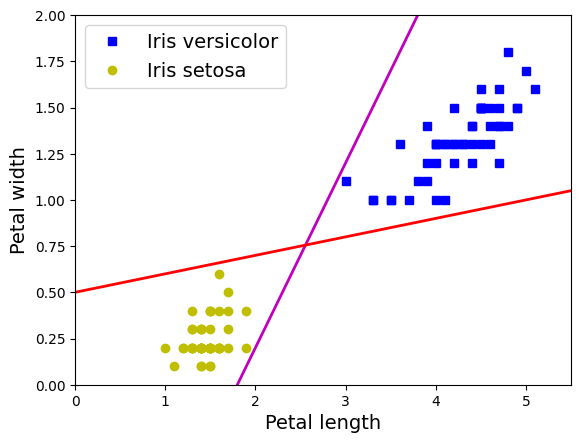

In [54]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5


plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()


While you can see that either of these lines perfectly well separates the two different iris types, they are right on the limit and it is very possible that more data of either sort of iris will just cross the boundary and be wrongly classified. In a SVM you try to find the line that provides the **greatest separation**. So lets try it.

`C` is called the regularization parameter, and must be a strictly positive float. Decreasing C corresponds to more regularization. This is discussed more later, but for now we set C to be a very large number, such that it is effectively infinite.

In [59]:
from sklearn.svm import SVC

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=100000000.0)
svm_clf.fit(X, y)

SVC(C=100000000.0, kernel='linear')

Now lets plot the result.

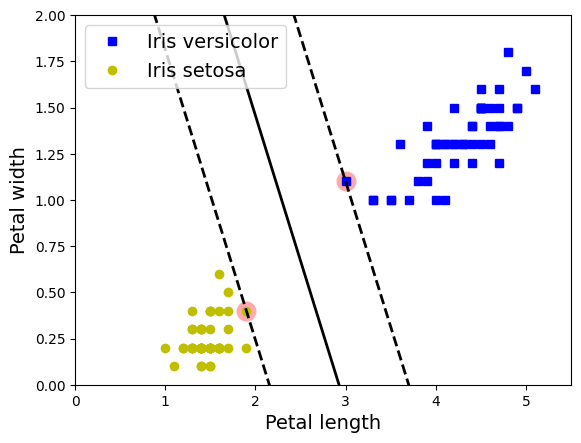

In [60]:
x0 = np.linspace(0, 5.5, 200)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

# retrieve the slope and the intercept
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0    ==>    x1 = -w0/w1 * x0 - b/w1
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

# now look at the margins
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

# now get the actual support vectors
svs = svm_clf.support_vectors_

# now draw the lines
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.axis([0, 5.5, 0, 2])

plt.show()

You can see that the SVM has chosen the line that has the greatest separation. The two marked points are nearest two points and these are the actual support vectors. You will also have noticed that adding more data that is "behind" the support vector makes no difference to the selected boundary.

One very valid point noted in **{homl}** is that SVM can very sensitive to feature scale. In the example below (taken from **{homl}** you can see the difference the preprocessor scaling can make.

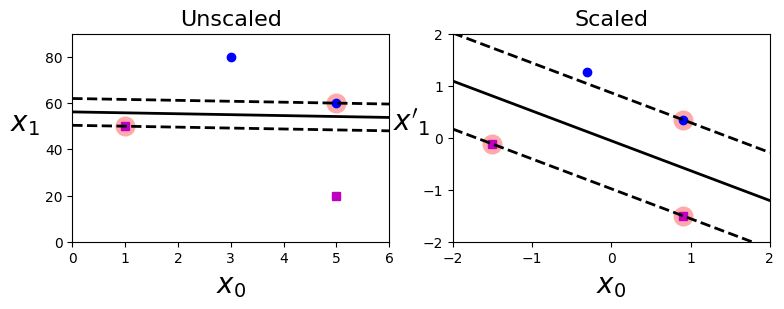

In [64]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear")
svm_clf.fit(Xs, ys)



def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# Now use the sklearn preprocessor to scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

You can see that Scaled plot looks a lot more healthy.

## Soft Margin Classification

What we have been doing so far is call hard margin classification. This has two significant problems. Firstly, the problem has to be linearly separable and secondly it is very sensitive to outliers. Lets see what we get if we introduce outliers into our iris dataset. 



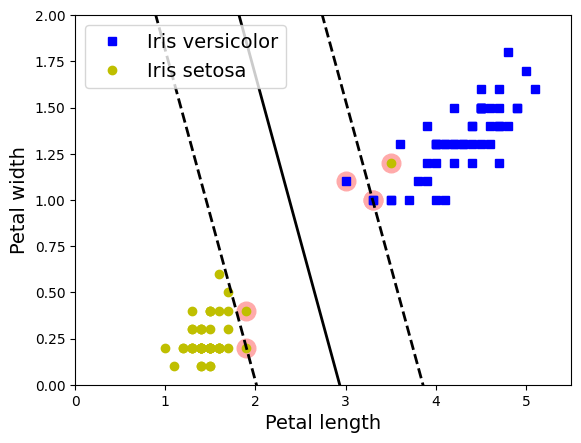

In [63]:
X_mod=X
X_mod=np.append(X,[[3.5,1.2]], axis=0)
y_mod=np.append(y,0)

#fit the new model and plot
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_mod, y_mod)

x0 = np.linspace(0, 5.5, 200)

plt.plot(X_mod[:, 0][y_mod==1], X_mod[:, 1][y_mod==1], "bs", label="Iris versicolor")
plt.plot(X_mod[:, 0][y_mod==0], X_mod[:, 1][y_mod==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

# retrieve the slope and the intercept
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

# now look at the margins
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

# now get the actual support vectors
svs = svm_clf.support_vectors_

# now draw the lines
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.axis([0, 5.5, 0, 2])

plt.show()

You can see that these data are no longer linearly separable and there is margin violation. There is a hyperparameter **C** than can be tune the behaviour of the SVM in these cases.  C is a regularistion coefficient that you can use to control this behaviour. C must always be positive but can be very small or very large. The default value of C is one.

<div style="background-color:#C2F5DD">

## Exercise

This is to familiarise yourselves to how `C` works. Take the code above, add a few more "outliers" and then plot the results for C going from small values (say 0.0001) to quite large values (say 1000000) and try to understand the behaviour.

# Nonlinear SVM Classification

Not all problems involve datasets which are linearly separable. However, many of these datasets do become linearly separable if you add features with higher polynomial terms (as we did with nonlinear regression). The most common straightforward example of this (and you see it in all the text books) is something like: 

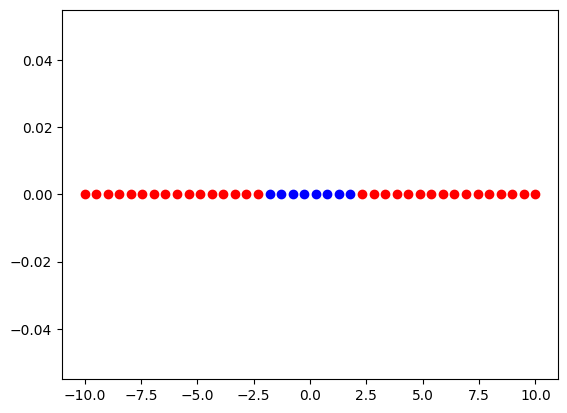

In [69]:
import numpy as np
import pylab as pl

X=np.linspace(-10,10,40)
y= [1 if np.abs(x) > 2 else 0 for x in X]

X_plot1=[X[i] for i in range(len(X)) if y[i]>0]
y_plot1=[0 for i in range(len(X)) if y[i]>0]

X_plot2=[X[i] for i in range(len(X)) if y[i]<1]
y_plot2=[0 for i in range(len(X)) if y[i]<1]

pl.plot(X_plot1,y_plot1,'ro')
pl.plot(X_plot2,y_plot2,'bo')



pl.show()



Each datapoint has one feature, and currently this dataset is not linearly separable. However, it will become linearly separable if add a second feature that is the square of the first. Mathematically, we want to add a feature $x_2 = (x_1)^2$

<div style="background-color:#C2F5DD">

## Exercise

Actually go through the exercise of showing this works using `PolynomialFeatures`. 
Run the cell below to see documentation for `PolynomialFeatures`.

In [ ]:
from IPython.display import IFrame
IFrame("https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#", width=900, height=800)

Now we are going to meet another famous ML data set (or rather,  a way of making data sets) that appears in text books. These are the SKLearn `make_moons`. Again I am taking a lot from **{homl}**.

We first get our dataset and visualise it.

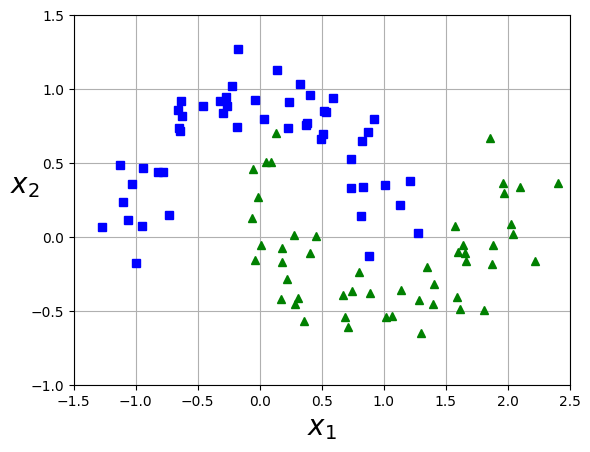

In [66]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

You can see that this creates two intertwined data sets.

We then create a pipeline, which is essentially a list of things we want to do to our data, including preprocessing it and using it to train our model.

For this we use `sklearn.pipeline.Pipeline`

In [67]:
#from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# so lets add a pipline that adds poly features and scales it.

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="linear", C=1)) # could use LinearSVC(C=10)) as this would be much faster
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, kernel='linear'))])

Now lets plot it

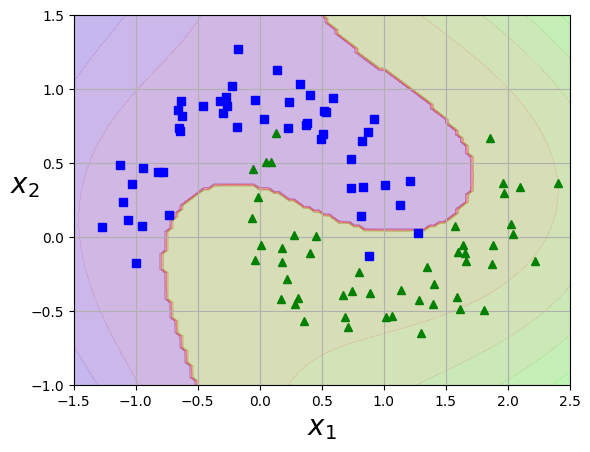

In [68]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])


plt.show()

Not bad at all. Try it with different values of C and it might get even better or worse! 

Adding polynomial featuures is a useful thing to do and often works. However, it can cause a significant increase in the number of featuresas you go to higher dimensionality, which vastly increases the time required to train our model.
Also, as things get more complicated lower polynomials no longer work well. 

Fortunately we have another trick up our sleeve  -- a kernel trick.

## The Purpose of Kernel Tricks

We have seen previously that data which may not be separable in $n$ dimensions can be separable in $m$ dimensions (where $m>n$), what we mean by this is that there exists no $n-1$ dimensional plane which can separate the datapoints. After the addition of extra features, we go from $n \rightarrow m$ features, such that there now exists a $m-1$ dimensional plane which does indeed separate the data. The drawback of this is the extra computation time required in finding this plane which comes with higher dimensional data.

Kernel Tricks have an effect similar to that of the addition of extra features, but without the downside of extra computation time.

# Polynomial Kernels

Sadly the maths behind kernel tricks are out of the scope of this practical course -- simply because we don't have enough time. Essentially it builds on pairs of points to have the same effect as adding polynomial features without adding them. It is worth looking up the maths as it is not too hard.

## Add the kernel maths here later

So lets try with a 3rd degree kernel. In the example below coef0 is a hyperparameter that determines how much the model is by high degree polynomials as opposed to low degree ones -- the default value is 0.

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=100, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

In [ ]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])

<div style="background-color:#C2F5DD">

## Exercise

This is for you to understand the behaviour of the SVM under different values of coef0, C and different degrees. Try changing them up to (say) a degree of ~15 and coef up to 100 with C over a large range.  

## Similarity Features

Another way to add more useful features would be to see the similarity between two points. One way of doing this would be to define a similarity function that is Gaussian *Radial Base Function* (RBF) so that the similarity between two points $x_1$ and $x_2$ is:

$\phi=e^{-\gamma |x_1-x_2|}$

where $\gamma$ is a tunable parameter.

If you then do this for every point you introduce many new features that will almost certainly have discriminating power. However, this procedure  too can result in spiraling number of features. So is there a kernel that can do this for us? Well yes there is.

## Gaussian RBF Kernel

$\gamma$ is a tunable hyperparameter. Increasing $\gamma$ makes the Gaussian narrower and decreasing it makes it broader. So from that point of view you can think of it as a sort of regulariser. It also means that if $\gamma$ is too large you will have a tendency to overfit your data and if it is too small you will have a tendency to underfit your data.

In [ ]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.01))
    ])
rbf_kernel_svm_clf.fit(X, y)
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])

<div style="background-color:#C2F5DD">

## Exercise
 
 To understand the effect of $\gamma$ and C try varying them over large ranges (say $0.001 \lt \gamma \lt 50$ and $0.001 \lt$C$\lt 100000$. Do this is a systematic way so that you understand what is going on.

### So with all these tunable hyperparameters how do you decide what values to use?

Well there is no magic answer. Always try to make it linear if you can as LinearSVC is very much faster than SVC(kernel="linear"). Some experience helps, looking at the problem can do as well.  Often a grid scan as you have done with the MNIST dataset is very useful indeed.

# SVM for regression

Whereas when you are using an SVM for classification you are trying to separate the different classes by as far as possible while limiting margin violation, in regression you are trying to do the opposite and include as many as you can within that margin. That margin is controlled by a hyperparameter $\epsilon$. 


In [ ]:
# lets make some data

np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()
from sklearn.svm import LinearSVR

# set up the regression
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

# find the support vectors
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg.support_ = find_support_vectors(svm_reg, X, y)

# now lets plot them
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])

<div style="background-color:#C2F5DD">

## Exercise 
Change the value of $\epsilon$ to see how it effects the regression

Also similar is the nonlinear case when you can use  a polynomial kernel. See the example below.

In [ ]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])

<div style="background-color:#C2F5DD">

## Exercise

Again see how this varies with $\epsilon$.